# Libraries imports and getting Dataset


In [4]:
import numpy as np
import tensorflow as tf
import pandas as pd
from glob import glob
import librosa as lr
import os
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
import scipy as sc
from numpy import linalg
import scipy.io
from os import listdir
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Loading Data

In [2]:
def LoadAudio(Crema):
    emotions = []
    timeLines=[]
    Audio_List=[]
    samp_freq=[]
    
    for wav in os.listdir(Crema):
        path=Crema+"/"+wav
        audio,sampling_freq=lr.load(path,sr=16000)
        yt, index = lr.effects.trim(audio, top_db=60)       
        

        if len(yt) > (3*16000):
            yt = yt[:3*16000]
        else:
            padding = (3*16000) - len(yt)
            offset = padding // 2
            yt = np.pad(yt, (offset,3*16000- len(yt) - offset), 'constant')
        # yt=lr.util.normalize(yt)  

        mean = np.mean(yt)
        std = np.std(yt)
        out = np.ones( (len(yt)) ) 
        yt= np.divide((yt - mean),std,out=out, where=std!=0)
        # yt = (yt - mean) / std #normalization & standarization
        Audio_List.append(yt)
        samp_freq.append(sampling_freq)
        timeLines.append(np.arange(0,len(yt))/sampling_freq)
        info = wav.partition(".wav")[0].split("_")
        if info[2] == 'SAD':
            emotions.append(0)
        elif info[2] == 'ANG':
            emotions.append(1)
        elif info[2] == 'DIS':
            emotions.append(2)
        elif info[2] == 'FEA':
            emotions.append(3)
        elif info[2] == 'HAP':
            emotions.append(4)
        elif info[2] == 'NEU':
            emotions.append(5)
        else:
            emotions.append(6)
            
    return Audio_List,timeLines,samp_freq,emotions

In [3]:
Audio_List,timeLines,samp_freq,Labels=  LoadAudio('/kaggle/input/speech-emotion-recognition-en/Crema')
print(len(Audio_List))
print(len(timeLines))
print(len(Labels))

7442
7442
7442


# Splitting Data

In [4]:
train_data, test_data, labels_train1D, labels_test1D = train_test_split(Audio_List,Labels, test_size=0.20, random_state=42)
train_data,val_data, labels_train1D, labels_val1D = train_test_split(train_data,labels_train1D, test_size=0.05, random_state=42)
print(len(train_data))
print(len(val_data))
print(len(test_data))

5357
596
1489


# Data Augmentation

In [5]:
# def noise(data):
#     noise_amp = 0.035*np.random.uniform()*np.amax(data)
#     data = data + noise_amp*np.random.normal(size=data.shape[0])
#     return data

# def shift(data):
#     shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
#     return np.roll(data, shift_range)


# Saeed

In [7]:
df = pd.read_csv('/kaggle/input/processed/processed.csv')
df = pd.DataFrame(df)
Labels=np.array(df['Labels'])
Audio_List = np.array(df)[:,0:-1]

In [8]:
Audio_List.shape

(18156, 128)

array([4, 4, 2, ..., 1, 0, 1])

13071
1453
3632


In [6]:
train_Aug=[]
for i in range(len(train_data)):
  train_Aug.append(train_data[i])
# for i in range(len(train_data)):

#   noise_data = noise(train_data[i])
#   train_Aug.append(noise_data)
#   labels_train1D.append(labels_train1D[i])

# for i in range(len(train_data)):
#   shift_data = shift(train_data[i])
#   train_Aug.append(shift_data)
#   labels_train1D.append(labels_train1D[i])
print(len(train_Aug))
print(len(labels_train1D))
print(len(train_data))

5357
5357
5357


# Feature extraction

In [7]:

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = lr.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

In [8]:
def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length

In [9]:
def extract_features(Audio_List, samp_freq, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(Audio_List, frame_length, hop_length),
                        np.mean(energy(Audio_List, frame_length, hop_length),axis=0)))
    
    rms = np.mean(lr.feature.rms(y=Audio_List).T, axis=0)
    result = np.hstack((result, rms))

    stft = np.abs(lr.stft(Audio_List))
    chroma_stft = np.mean(lr.feature.chroma_stft(S=stft, sr=16000).T, axis=0)
    result = np.hstack((result, chroma_stft))

    mfcc = np.mean(lr.feature.mfcc(y=Audio_List, sr=16000).T, axis=0)
    result = np.hstack((result, mfcc))

    return result

In [10]:
features_Aug=[]
for i in range(len(train_Aug)):
    
    res1 = extract_features(train_Aug[i],16000)
    result = np.array(res1)
    features_Aug.append(result)

In [11]:
features_val=[]
for i in range(len(val_data)):
    
    res1 = extract_features(val_data[i],16000)
    result = np.array(res1)
    features_val.append(result)

In [12]:
features_test=[]
for i in range(len(test_data)):
    
    res1 = extract_features(test_data[i],16000)
    result = np.array(res1)
    features_test.append(result)

/opt/conda/lib/python3.10/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [19]:
combined_data = np.concatenate((np.squeeze(features_Aug), np.squeeze(features_val), np.squeeze(features_test)), axis=0)
to_extract = pd.DataFrame(combined_data)

In [20]:
to_extract

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000488,...,-5.741843,-1.795399,-1.764801,-1.589083,1.982869,-1.874924,1.638678,0.380094,-4.079356,-1.494381
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.009277,0.019043,0.026855,0.039062,0.036133,...,-17.827354,1.725509,-4.907444,-0.719310,-1.063102,-10.001004,-5.542165,3.812808,-7.570259,-1.556370
2,0.016113,0.033203,0.043457,0.055664,0.048828,0.044922,0.048340,0.044434,0.047363,0.045898,...,4.765302,0.033536,-6.618848,0.142652,-3.586911,-5.711392,-1.832352,-3.596347,-4.154062,-5.048596
3,0.000000,0.000000,0.000000,0.021484,0.027344,0.040039,0.048828,0.039551,0.044434,0.043457,...,-1.846701,-2.393814,-2.987235,-6.442640,-4.951312,-2.014593,1.170899,1.272606,-2.483069,0.460955
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.288166,1.826450,-2.634983,-0.139737,-3.449677,-2.519706,-1.141160,-1.990780,-2.433681,0.610783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001953,0.014648,0.021973,0.033203,...,-1.263227,-1.319768,-3.525696,-1.919538,-4.130930,-1.911671,0.360066,0.206297,-1.390071,-0.402314
18152,0.026855,0.035156,0.050781,0.059082,0.056641,0.063965,0.061523,0.054199,0.048340,0.044434,...,-3.272821,-4.573730,-6.803200,-4.052277,0.579298,-3.985453,-3.587948,-1.355567,-3.667694,-0.937285
18153,0.023438,0.027832,0.033203,0.026367,0.020508,0.020996,0.020508,0.018066,0.018555,0.018066,...,-6.840354,-0.759527,-3.398011,-0.155729,-3.213560,-7.125738,4.233753,-2.013582,-4.657226,1.227784
18154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.520888,-2.257683,2.151526,-4.702983,-3.845220,-0.810273,-6.126133,-1.454368,-2.788211,-2.468552


In [32]:
labels = np.concatenate((np.array(labels_train1D),np.array(labels_test1D),np.array(labels_val1D)), axis=0)
to_extract['Labels']=labels


In [34]:
processed_data_path='./processed.csv'
to_extract.to_csv(processed_data_path,index=False)

In [16]:
features_Aug.shape

(13071, 128)

# **Run here after saving the dataset**

In [35]:
df = pd.read_csv('/kaggle/input/processed/processed.csv')
df = pd.DataFrame(df)
Labels=np.array(df['Labels'])
Audio_List = np.array(df)[:,0:-1]

In [43]:
features_Aug, features_test, labels_train, labels_test1D = train_test_split(Audio_List,Labels, test_size=0.30, random_state=42,stratify=Labels)
features_Aug,features_val, labels_train1D, labels_val1D = train_test_split(features_Aug,labels_train, test_size=0.05, random_state=42,stratify=labels_train)
print(len(features_Aug))
print(len(features_val))
print(len(features_test))

12073
636
5447


In [44]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
features_Aug=scaler.fit_transform(features_Aug)
features_test=scaler.transform(features_test)
features_val=scaler.transform(features_val)

In [45]:
features_Aug = np.array(features_Aug)
features_Aug = features_Aug[:,:,np.newaxis]
features_val = np.array(features_val)
features_val = features_val[:,:,np.newaxis]
features_test = np.array(features_test)
features_test = features_test[:,:,np.newaxis]
features_test.shape

(5447, 128, 1)

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def measurements_of_accuracy(Y_test,Y_pred,classifier,labels):
    # Calculate the confusion matrix
    Y_pred = np.argmax(Y_pred,axis=1)
    conf_matrix = confusion_matrix(y_true=Y_test, y_pred=Y_pred)
    matrix_precentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')
 
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title("Confusion Matrix for "+classifier+"Classifier", fontsize=18)
    plt.grid(False)
    plt.xticks(range(len(labels)), labels, rotation=90)  # Set x-axis labels
    plt.yticks(range(len(labels)), labels)  # Set y-axis labels
    plt.show()
    
    #Accuracy
    print('Accuracy : %.4f' % accuracy_score(Y_test, Y_pred))

    #precision score
    print('Precision : %.4f' % precision_score(Y_test, Y_pred,average='macro'))
    
    #Recall Score
    print('Recall : %.4f' % recall_score(Y_test, Y_pred,average='macro'))
    
    #F1 score
    print('F1 Score : %.4f' % f1_score(Y_test, Y_pred,average='macro'))
    
        # Find the most confusing classes
    misclassification_rates = 1 - np.diag(matrix_precentage)
    most_confusing_classes = [labels[i] for i in np.argsort(misclassification_rates)[::-1]]
    print("Most Confusing Classes:")
    for i, label in enumerate(most_confusing_classes):
        rate_percentage = misclassification_rates[i] * 100
        print(f"{i + 1}. {label}: {rate_percentage:.2f}% (Misclassification rate)")

In [37]:
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
#BUILD 1D CNN LAYERS0
model = tf.keras.Sequential()
model.add(layers.Conv1D(512, kernel_size=(5), activation='relu',padding='same', input_shape=(features_Aug.shape[1],1)))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=(5),strides=2,padding='same'))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(512, kernel_size=(5), activation='relu',strides=1,padding='same',input_shape=(features_Aug.shape[1],1)))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=(5),strides=2))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(256, kernel_size=(3), activation='relu',strides=1,padding='same',input_shape=(features_Aug.shape[1],1)))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=(5),strides=2))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(3), activation='relu',strides=1,padding='same',input_shape=(features_Aug.shape[1],1)))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=(5),strides=2))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(7, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=5.00e-04)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt ,metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 128, 512)          3072      
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 64, 512)          0         
 g1D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 64, 512)           0         
                                                                 
 conv1d_23 (Conv1D)          (None, 64, 512)           1311232   
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 30, 512)          0         
 g1D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 30, 512)          

In [38]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.utils import compute_class_weight

model_history = model.fit(np.array(features_Aug),np.array(labels_train1D),batch_size=32,epochs=150,validation_data=(np.array(features_val), np.array(labels_val1D)))
score, acc = model.evaluate(np.array(features_val), np.array(labels_val1D), verbose=0)
print('Val accuracy:', acc)

Epoch 1/150
378/378 [==============================] - 6s 10ms/step - loss: 1.7492 - accuracy: 0.2513 - val_loss: 1.7064 - val_accuracy: 0.3050
Epoch 2/150
378/378 [==============================] - 3s 9ms/step - loss: 1.6594 - accuracy: 0.2984 - val_loss: 1.6944 - val_accuracy: 0.3066
Epoch 3/150
378/378 [==============================] - 3s 9ms/step - loss: 1.6165 - accuracy: 0.3305 - val_loss: 1.5992 - val_accuracy: 0.3333
Epoch 4/150
378/378 [==============================] - 3s 9ms/step - loss: 1.5886 - accuracy: 0.3499 - val_loss: 1.5843 - val_accuracy: 0.3632
Epoch 5/150
378/378 [==============================] - 3s 9ms/step - loss: 1.5734 - accuracy: 0.3620 - val_loss: 1.5771 - val_accuracy: 0.3774
Epoch 6/150
378/378 [==============================] - 3s 9ms/step - loss: 1.5624 - accuracy: 0.3660 - val_loss: 1.5552 - val_accuracy: 0.3632
Epoch 7/150
378/378 [==============================] - 3s 9ms/step - loss: 1.5512 - accuracy: 0.3729 - val_loss: 1.5542 - val_accuracy: 0.369

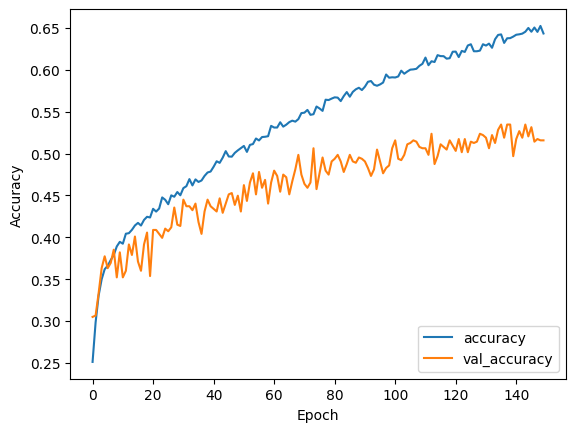

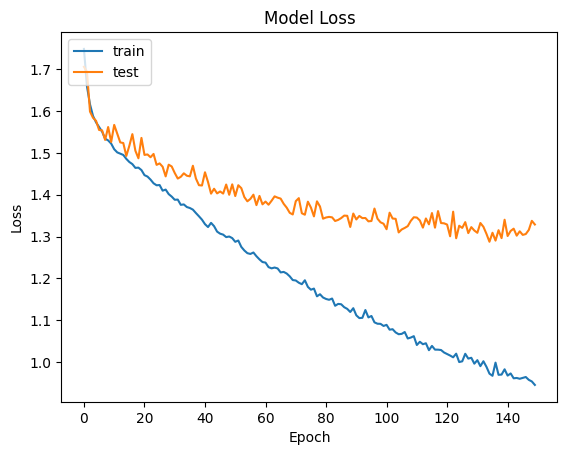

In [39]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
label_mapping = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}

171/171 [==============================] - 1s 3ms/step


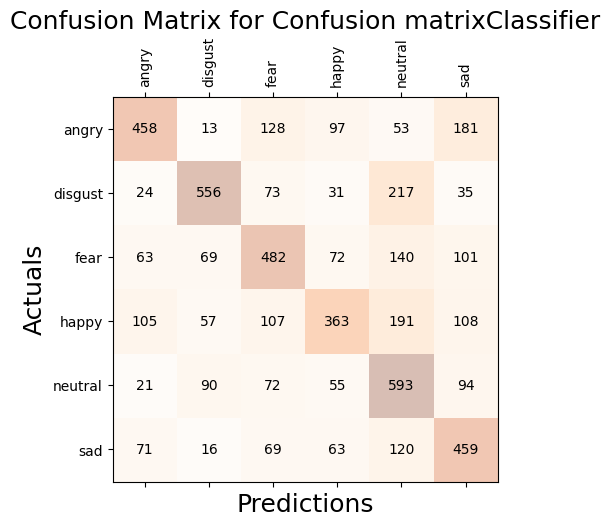

Accuracy : 0.5344
Precision : 0.5471
Recall : 0.5354
F1 Score : 0.5340
Most Confusing Classes:
1. happy: 50.75% (Misclassification rate)
2. angry: 40.60% (Misclassification rate)
3. fear: 48.00% (Misclassification rate)
4. sad: 61.01% (Misclassification rate)
5. disgust: 35.89% (Misclassification rate)
6. neutral: 42.48% (Misclassification rate)
              precision    recall  f1-score   support

           0       0.62      0.49      0.55       930
           1       0.69      0.59      0.64       936
           2       0.52      0.52      0.52       927
           3       0.53      0.39      0.45       931
           4       0.45      0.64      0.53       925
           5       0.47      0.58      0.52       798

    accuracy                           0.53      5447
   macro avg       0.55      0.54      0.53      5447
weighted avg       0.55      0.53      0.53      5447



In [41]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
import seaborn as sns
score, trainacc = model.evaluate(np.array(features_Aug), np.array(labels_train1D), verbose=0)
y_pred = model.predict(features_test)
measurements_of_accuracy(labels_test1D,y_pred,"Confusion matrix",list(label_mapping.keys()))

report=metrics.classification_report(labels_test1D,np.argmax(y_pred,axis=1)) 
print(report)

# matrix = metrics.confusion_matrix(labels_test1D ,np.argmax(y_pred,axis=1))
# sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r',xticklabels = ['SAD','ANGER','DISGUSTED','FEAR','HAPPY','NEUTRAL'],yticklabels = ['SAD','ANGER','DISGUSTED','FEAR','HAPPY','NEUTRAL'])

# print('val accuracy:', acc*100)
# print('train accuracy:', trainacc*100)
# print("test accuracy",metrics.accuracy_score(labels_test1D,np.argmax(y_pred,axis=1))*100)

### Best results

In [42]:
model = Sequential()
# 1 stride
model.add(layers.Conv1D(512, 5,padding='same',input_shape=(features_Aug.shape[1],1), activation='relu'))
# max pool
model.add(layers.MaxPool1D( pool_size=5))

# 2 strides
model.add(layers.Conv1D(128, 5,padding='same',activation='relu'))
model.add(layers.Conv1D(128, 5,padding='same',activation='relu'))

# max pool
model.add(layers.MaxPool1D( pool_size=5,padding='same'))

# dropout
model.add(layers.Dropout(0.5))

# flatten to add fully connected layer
model.add(layers.Flatten())

# fully connected layer
model.add(layers.Dense(512, activation ='relu'))
# dropout
model.add(layers.Dropout(0.5))

# fully connected layer
model.add(layers.Dense(64, activation ='relu'))
# output layer
model.add(layers.Dense(6, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt ,metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_26 (Conv1D)          (None, 128, 512)          3072      
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 25, 512)          0         
 g1D)                                                            
                                                                 
 conv1d_27 (Conv1D)          (None, 25, 128)           327808    
                                                                 
 conv1d_28 (Conv1D)          (None, 25, 128)           82048     
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 5, 128)           0         
 g1D)                                                            
                                                                 
 dropout_29 (Dropout)        (None, 5, 128)           

In [43]:
model_history = model.fit(np.array(features_Aug),np.array(labels_train1D),batch_size=32,epochs=300,validation_data=(np.array(features_val), np.array(labels_val1D)))
score, acc = model.evaluate(np.array(features_val), np.array(labels_val1D), verbose=0)
print('Val accuracy:', acc)

Epoch 1/300
378/378 [==============================] - 4s 5ms/step - loss: 1.7261 - accuracy: 0.2501 - val_loss: 1.6496 - val_accuracy: 0.2940
Epoch 2/300
378/378 [==============================] - 2s 5ms/step - loss: 1.6430 - accuracy: 0.3065 - val_loss: 1.5874 - val_accuracy: 0.3459
Epoch 3/300
378/378 [==============================] - 2s 5ms/step - loss: 1.5958 - accuracy: 0.3376 - val_loss: 1.5644 - val_accuracy: 0.3459
Epoch 4/300
378/378 [==============================] - 2s 5ms/step - loss: 1.5731 - accuracy: 0.3570 - val_loss: 1.5544 - val_accuracy: 0.3821
Epoch 5/300
378/378 [==============================] - 2s 5ms/step - loss: 1.5516 - accuracy: 0.3695 - val_loss: 1.5309 - val_accuracy: 0.3852
Epoch 6/300
378/378 [==============================] - 2s 5ms/step - loss: 1.5338 - accuracy: 0.3841 - val_loss: 1.5141 - val_accuracy: 0.3947
Epoch 7/300
378/378 [==============================] - 2s 5ms/step - loss: 1.5206 - accuracy: 0.3918 - val_loss: 1.4974 - val_accuracy: 0.4009

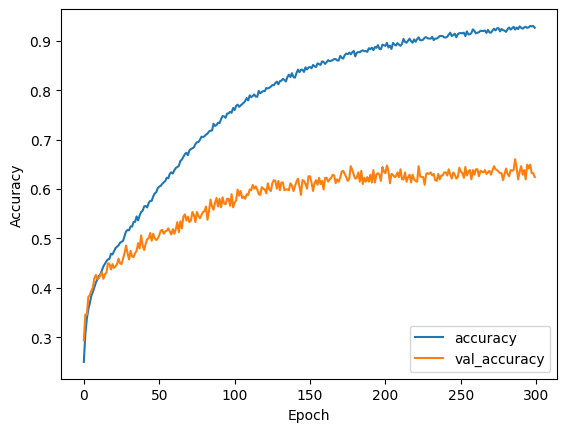

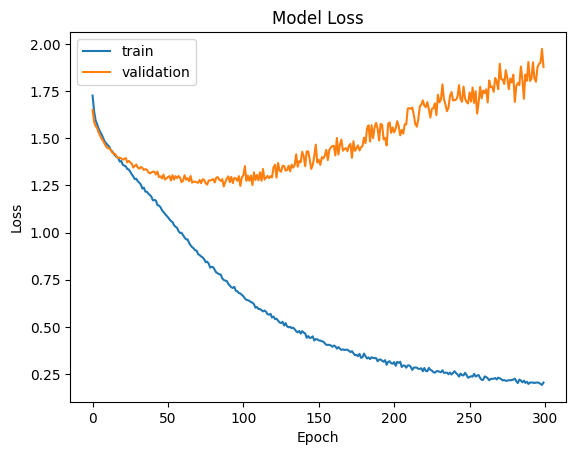

In [44]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

171/171 [==============================] - 0s 2ms/step


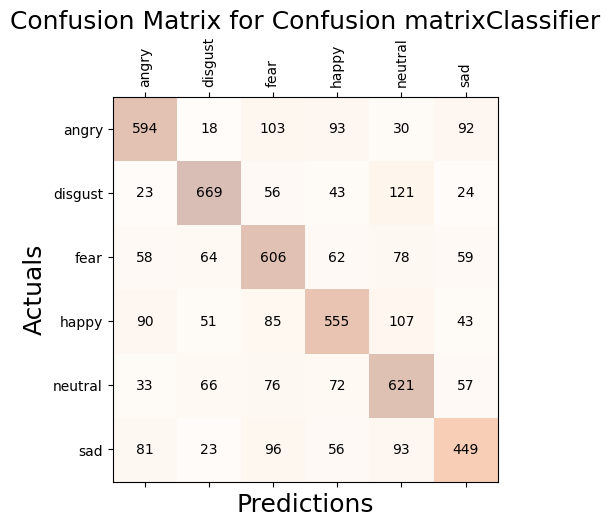

Accuracy : 0.6415
Precision : 0.6435
Recall : 0.6396
F1 Score : 0.6404
Most Confusing Classes:
1. sad: 36.13% (Misclassification rate)
2. happy: 28.53% (Misclassification rate)
3. angry: 34.63% (Misclassification rate)
4. fear: 40.39% (Misclassification rate)
5. neutral: 32.86% (Misclassification rate)
6. disgust: 43.73% (Misclassification rate)
              precision    recall  f1-score   support

           0       0.68      0.64      0.66       930
           1       0.75      0.71      0.73       936
           2       0.59      0.65      0.62       927
           3       0.63      0.60      0.61       931
           4       0.59      0.67      0.63       925
           5       0.62      0.56      0.59       798

    accuracy                           0.64      5447
   macro avg       0.64      0.64      0.64      5447
weighted avg       0.64      0.64      0.64      5447



In [45]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
import seaborn as sns
score, trainacc = model.evaluate(np.array(features_Aug), np.array(labels_train1D), verbose=0)
y_pred = model.predict(features_test)
measurements_of_accuracy(labels_test1D,y_pred,"Confusion matrix",list(label_mapping.keys()))

report=metrics.classification_report(labels_test1D,np.argmax(y_pred,axis=1)) 
print(report)

# matrix = metrics.confusion_matrix(labels_test1D ,np.argmax(y_pred,axis=1))
# sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r',xticklabels = ['SAD','ANGER','DISGUSTED','FEAR','HAPPY','NEUTRAL'],yticklabels = ['SAD','ANGER','DISGUSTED','FEAR','HAPPY','NEUTRAL'])

# print('val accuracy:', acc*100)
# print('train accuracy:', trainacc*100)
# print("test accuracy",metrics.accuracy_score(labels_test1D,np.argmax(y_pred,axis=1))*100)